In [2]:

import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns  
import missingno as msno 

from prophet import Prophet # time series forecasting

from scipy.stats import chi2_contingency, f_oneway


pd.set_option('display.max_columns', None)

## Loading Dataset

In [3]:
file_name = 'crime_incidents_2024_cleaned.csv'
data_dir = '../data/processed'

dataset_path = os.path.join(os.path.join(data_dir, file_name))

print(f"Reading dataset from {dataset_path}")

Reading dataset from ../data/processed\crime_incidents_2024_cleaned.csv


In [4]:
crime_data_2024 = pd.read_csv(dataset_path)

# Creating a copy of the dataset
data = crime_data_2024.copy()
data.head()

,x,y,ccn,report_dat,shift,method,offense,block,xblock,yblock,ward,anc,district,psa,neighborhood_cluster,block_group,census_tract,voting_precinct,latitude,longitude,start_date,end_date,objectid
0,399581.51,129706.92,5094764,2024/09/30 04:00:00+00,MIDNIGHT,GUN,HOMICIDE,100 - 146 BLOCK OF WAYNE PLACE SE,399581.51,129706.92,8.0,8D,7.0,707.0,Cluster 39,009803 3,9803.0,Precinct 124,38.835154,-77.004820,2005/07/18 08:40:00+00,2024/09/30 13:30:00+00,663361652
1,397318.16,139543.86,23041354,2024/11/29 05:00:00+00,MIDNIGHT,OTHERS,HOMICIDE,1300 - 1399 BLOCK OF EUCLID STREET NW,397318.16,139543.86,1.0,1B,3.0,304.0,Cluster 2,003600 1,3600.0,Precinct 23,38.923765,-77.030927,2023/03/17 01:57:00+00,2023/03/17 06:30:00+00,663581216
2,397833.87,138551.89,23101994,2024/02/07 18:11:44+00,DAY,OTHERS,THEFT F/AUTO,900 - 999 BLOCK OF WESTMINSTER STREET NW,397833.87,138551.89,1.0,1B,3.0,305.0,Cluster 3,004402 2,4402.0,Precinct 137,38.914830,-77.024977,2023/06/25 07:34:00+00,2023/06/25 08:09:00+00,663585104
3,397576.99,143086.85,20160181,2024/05/22 04:00:00+00,MIDNIGHT,GUN,HOMICIDE,5401 - 5499 BLOCK OF GEORGIA AVENUE NW,397576.99,143086.85,4.0,4D,4.0,403.0,Cluster 18,002101 5,2101.0,Precinct 56,38.955682,-77.027955,2020/11/09 02:03:53+00,2020/11/09 02:20:49+00,663637331
4,399081.19,139270.15,24195223,2024/12/18 03:53:08+00,EVENING,OTHERS,THEFT/OTHER,1 - 99 BLOCK OF BRYANT STREET NW,399081.19,139270.15,5.0,5E,3.0,306.0,Cluster 21,003301 1,3301.0,Precinct 135,38.921303,-77.010595,2024/12/17 20:37:00+00,2024/12/17 23:34:00+00,663642831


In [26]:
data.isnull().sum() 

x                       0
y                       0
ccn                     0
report_dat              0
shift                   0
method                  0
offense                 0
block                   0
xblock                  0
yblock                  0
ward                    0
anc                     0
district                0
psa                     0
neighborhood_cluster    0
block_group             0
census_tract            0
voting_precinct         0
latitude                0
longitude               0
start_date              0
end_date                0
objectid                0
Month                   0
crime_type              0
dtype: int64

## Exploratory Data Analysis

#### When and where do most crimes occur?

In [5]:
# Converting the 'report_dat' column to datetime format
data['report_dat'] = pd.to_datetime(data['report_dat'])


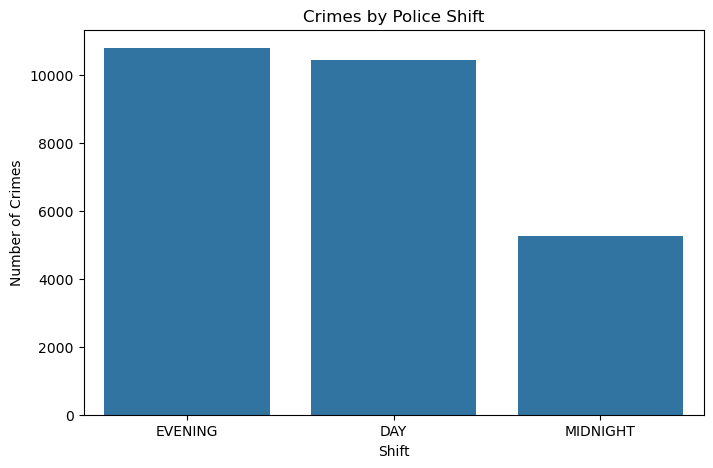

In [6]:
# Temporal Analysis

shift_counts = data['shift'].value_counts()

plt.figure(figsize=(8, 5))
sns.barplot(x=shift_counts.index, y=shift_counts.values)
plt.title("Crimes by Police Shift")
plt.xlabel("Shift")
plt.ylabel("Number of Crimes")
plt.show()

**Most crimes happen in the evening.**

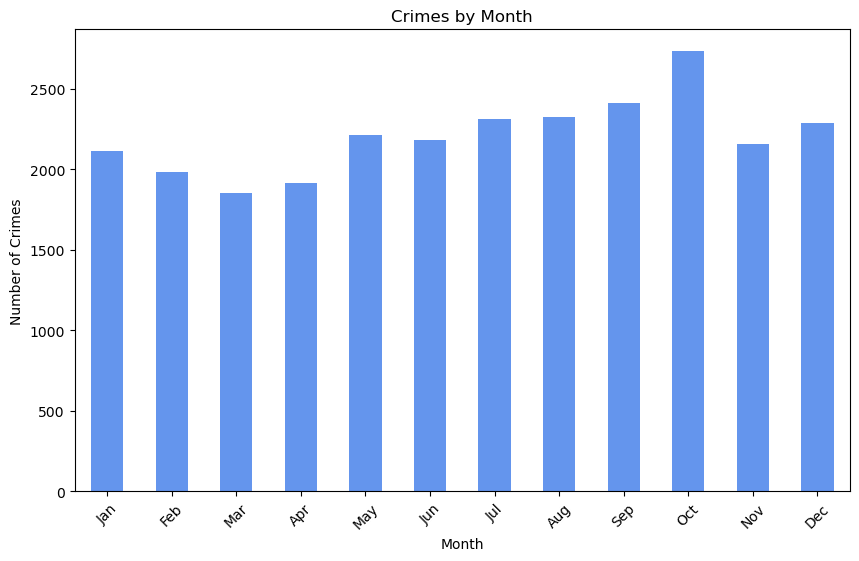

In [7]:
# Temporal Analysis: Crimes by Month
data['Month'] = data['report_dat'].dt.month
monthly_crime = data['Month'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
monthly_crime.plot(kind='bar', color='cornflowerblue')
plt.title("Crimes by Month")
plt.xlabel("Month")
plt.ylabel("Number of Crimes")
plt.xticks(ticks=range(12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.show()

**Most crimes happened in October.**

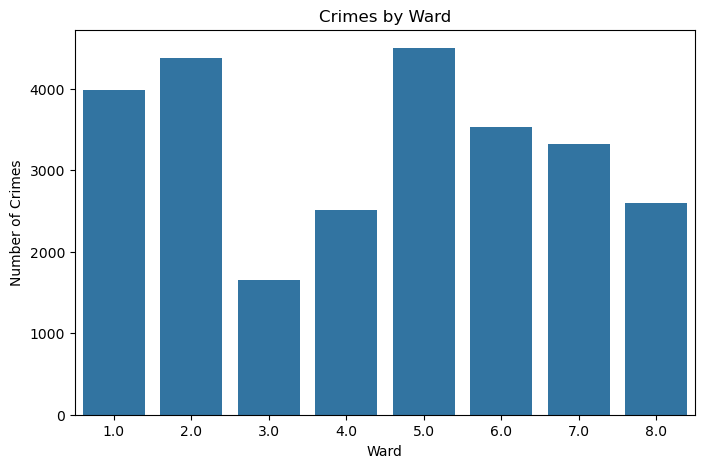

In [8]:
ward_counts = data['ward'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=ward_counts.index, y=ward_counts.values)
plt.title("Crimes by Ward")
plt.xlabel("Ward")
plt.ylabel("Number of Crimes")
plt.show()

**Most crimes happened in the 2nd and 5th ward while the least crimes occured in 3rd ward.**

#### What are the most common types of crimes?

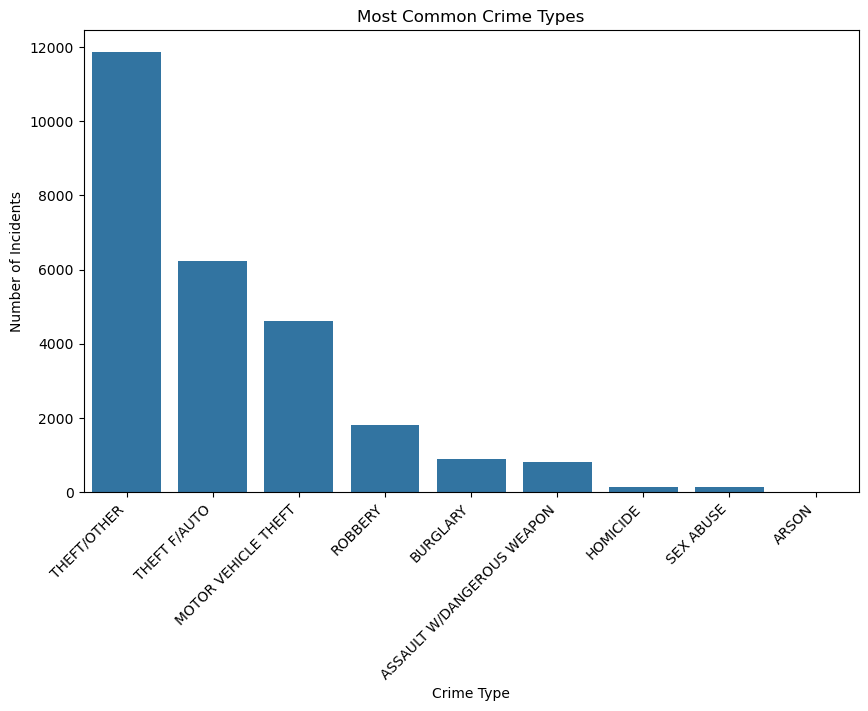

In [9]:
offense_counts = data['offense'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=offense_counts.index[:10], y=offense_counts.values[:10])
plt.title("Most Common Crime Types")
plt.xlabel("Crime Type")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.show()


**THEFT is the most common crime type.**

#### What methods are most commonly used in crimes?

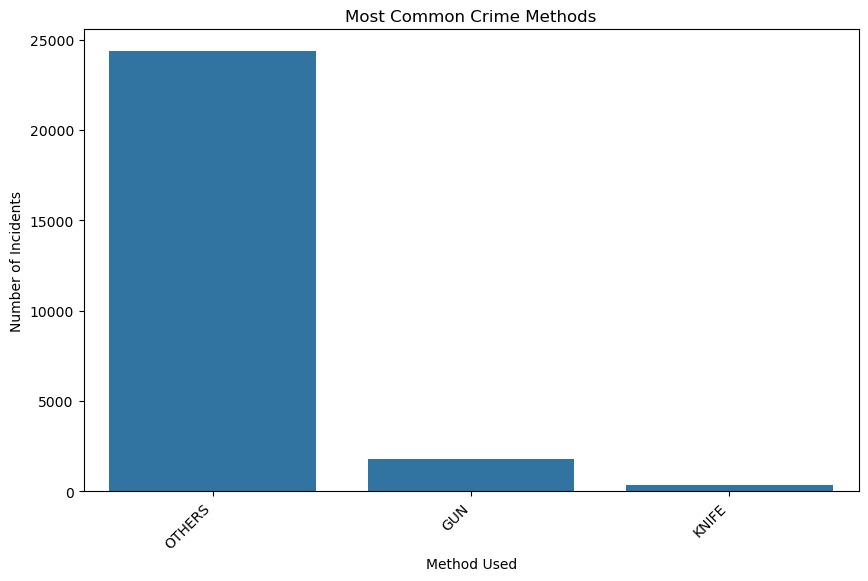

In [10]:
method_counts = data['method'].value_counts()
#method_counts

plt.figure(figsize=(10, 6))
sns.barplot(x=method_counts.index, y=method_counts.values)
plt.title("Most Common Crime Methods")
plt.xlabel("Method Used")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45, ha='right')
plt.show()

**Guns and knifes are not the most common crime methods.**

#### Which areas are high-crime hotspots?

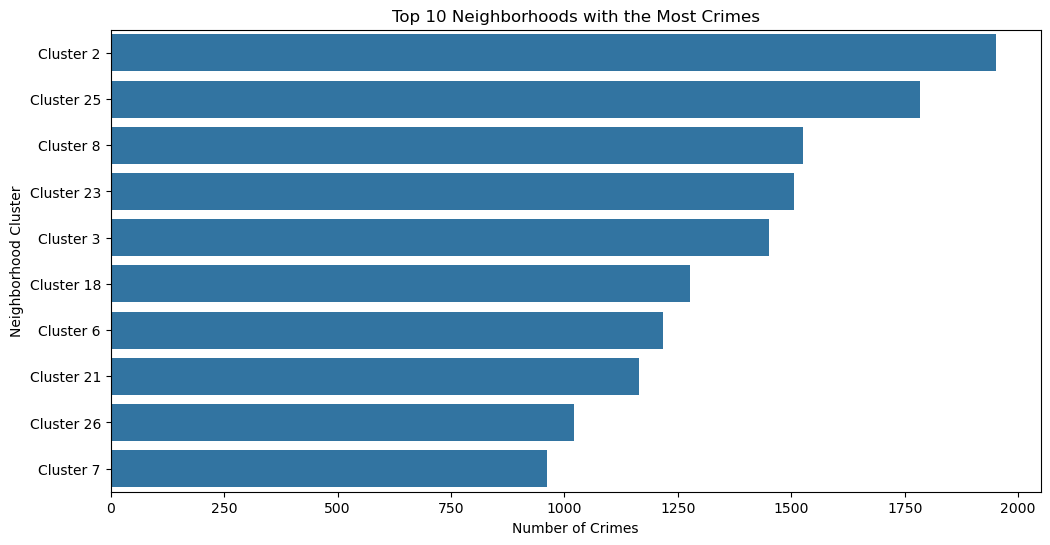

In [11]:
neighborhood_counts = data['neighborhood_cluster'].value_counts()

plt.figure(figsize=(12, 6))
sns.barplot(y=neighborhood_counts.index[:10], x=neighborhood_counts.values[:10])
plt.title("Top 10 Neighborhoods with the Most Crimes")
plt.xlabel("Number of Crimes")
plt.ylabel("Neighborhood Cluster")
plt.show()

**Neighborhood Cluster 2 has the most number of crimes that have occured**

#### Are certain crimes more likely during specific times (e.g., evening vs. day shift)

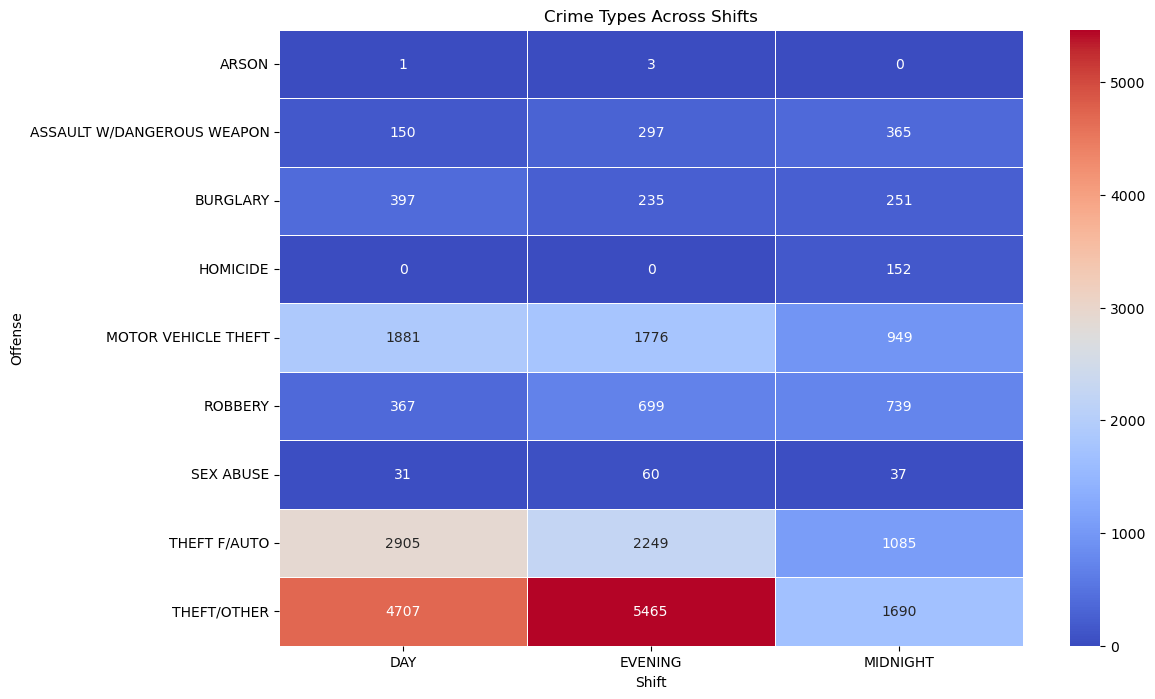

In [12]:
shift_offense_counts = data.groupby(['shift', 'offense']).size().reset_index(name='Count')

shift_offense_counts_pivot_data = shift_offense_counts.pivot(index='offense', columns='shift', values='Count').fillna(0)

# Visualization: Heatmap of crimes by shift and offense
plt.figure(figsize=(12, 8))
sns.heatmap(shift_offense_counts_pivot_data, annot=True, fmt=".0f", cmap="coolwarm", linewidths=.5)
plt.title("Crime Types Across Shifts")
plt.xlabel("Shift")
plt.ylabel("Offense")
plt.show()


#### How does crime differ across neighborhoods or wards?


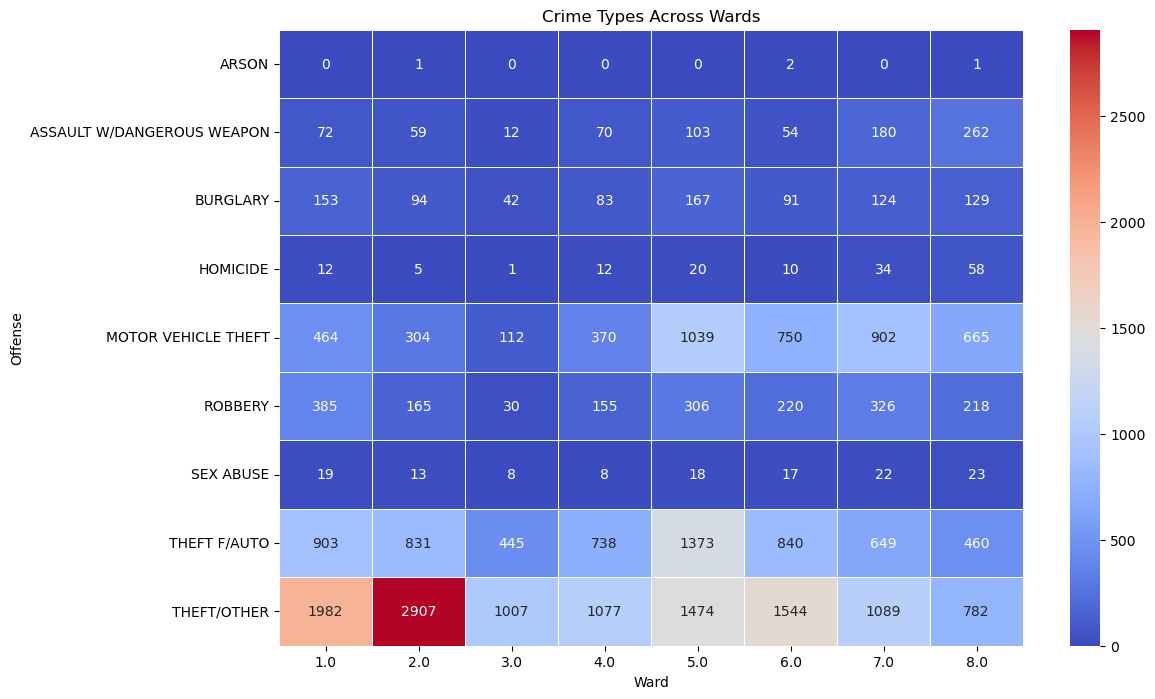

In [13]:
location_offense_counts = data.groupby(['ward', 'offense']).size().reset_index(name='count')

pivot_data = location_offense_counts.pivot(index='offense', columns='ward', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt=".0f", cmap="coolwarm", linewidths=.5)
plt.title("Crime Types Across Wards")
plt.xlabel("Ward")
plt.ylabel("Offense")
plt.show()

In [14]:
## OPTIONAL: Visualizing the number of crimes by neighborhood cluster
# neighborhood_crime_counts = data.groupby('neighborhood_cluster').size().reset_index(name='count')

# neighborhood_crime_counts = neighborhood_crime_counts.sort_values('count', ascending=False)

# plt.figure(figsize=(14, 8))
# sns.barplot(x='neighborhood_cluster', y='count', data=neighborhood_crime_counts)
# plt.title("Crimes by Neighborhood Cluster")
# plt.xlabel("Neighborhood Cluster")
# plt.ylabel("Number of Crimes")
# plt.xticks(rotation=90)
# plt.show()

#### Are violent crimes (e.g., robbery, assault) more prevalent in certain areas compared to property crimes (e.g., theft)?

In [15]:
violent_crimes = ['ROBBERY', 'ASSAULT W/DANGEROUS WEAPON', 'HOMICIDE', 'SEX ABUSE', 'ARSON']
property_crimes = ['THEFT/OTHER', 'THEFT F/AUTO', 'MOTOR VEHICLE THEFT', 'BURGLARY']

data['crime_type'] = data['offense'].apply(lambda x: 'violent' if x in violent_crimes else ('property' if x in property_crimes else 'other'))
data.head()

,x,y,ccn,report_dat,shift,method,offense,block,xblock,yblock,ward,anc,district,psa,neighborhood_cluster,block_group,census_tract,voting_precinct,latitude,longitude,start_date,end_date,objectid,Month,crime_type
0,399581.51,129706.92,5094764,2024-09-30 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,100 - 146 BLOCK OF WAYNE PLACE SE,399581.51,129706.92,8.0,8D,7.0,707.0,Cluster 39,009803 3,9803.0,Precinct 124,38.835154,-77.004820,2005/07/18 08:40:00+00,2024/09/30 13:30:00+00,663361652,9,violent
1,397318.16,139543.86,23041354,2024-11-29 05:00:00+00:00,MIDNIGHT,OTHERS,HOMICIDE,1300 - 1399 BLOCK OF EUCLID STREET NW,397318.16,139543.86,1.0,1B,3.0,304.0,Cluster 2,003600 1,3600.0,Precinct 23,38.923765,-77.030927,2023/03/17 01:57:00+00,2023/03/17 06:30:00+00,663581216,11,violent
2,397833.87,138551.89,23101994,2024-02-07 18:11:44+00:00,DAY,OTHERS,THEFT F/AUTO,900 - 999 BLOCK OF WESTMINSTER STREET NW,397833.87,138551.89,1.0,1B,3.0,305.0,Cluster 3,004402 2,4402.0,Precinct 137,38.914830,-77.024977,2023/06/25 07:34:00+00,2023/06/25 08:09:00+00,663585104,2,property
3,397576.99,143086.85,20160181,2024-05-22 04:00:00+00:00,MIDNIGHT,GUN,HOMICIDE,5401 - 5499 BLOCK OF GEORGIA AVENUE NW,397576.99,143086.85,4.0,4D,4.0,403.0,Cluster 18,002101 5,2101.0,Precinct 56,38.955682,-77.027955,2020/11/09 02:03:53+00,2020/11/09 02:20:49+00,663637331,5,violent
4,399081.19,139270.15,24195223,2024-12-18 03:53:08+00:00,EVENING,OTHERS,THEFT/OTHER,1 - 99 BLOCK OF BRYANT STREET NW,399081.19,139270.15,5.0,5E,3.0,306.0,Cluster 21,003301 1,3301.0,Precinct 135,38.921303,-77.010595,2024/12/17 20:37:00+00,2024/12/17 23:34:00+00,663642831,12,property


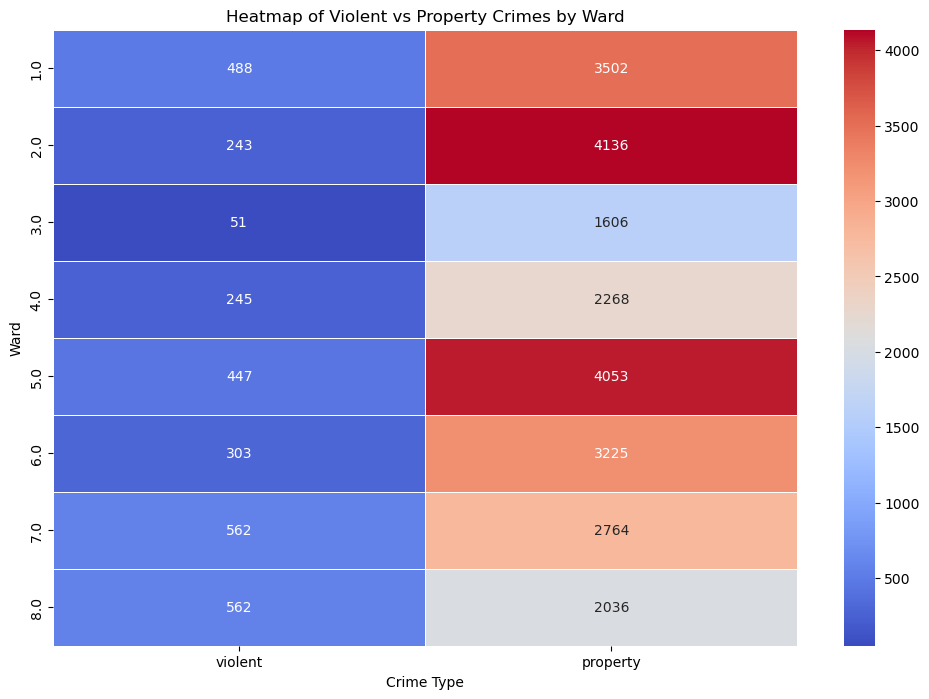

In [16]:
crime_type_counts = data.groupby(['ward', 'crime_type']).size().reset_index(name='count')

# Pivot table for visualization
pivot_crime_types = crime_type_counts.pivot(index='ward', columns='crime_type', values='count').fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_crime_types[['violent', 'property']], annot=True, cmap='coolwarm', fmt='g', linewidths=0.5)
plt.title("Heatmap of Violent vs Property Crimes by Ward")
plt.xlabel("Crime Type")
plt.ylabel("Ward")
plt.show()

In [17]:
# # Optional: Group by neighborhood cluster and crime type
# neighborhood_crime_type_counts = data.groupby(['neighborhood_cluster', 'crime_type']).size().reset_index(name='count')

# # Pivot table for neighborhood clusters
# pivot_neighborhood_crimes = neighborhood_crime_type_counts.pivot(index='neighborhood_cluster', columns='crime_type', values='count').fillna(0)

# # Plot heatmap for Violent vs Property Crimes by Neighborhood
# plt.figure(figsize=(14, 8))
# sns.heatmap(pivot_neighborhood_crimes[['violent', 'property']], annot=True, cmap='coolwarm', fmt='g', linewidths=0.5)
# plt.title("Heatmap of Violent vs Property Crimes by Neighborhood Cluster")
# plt.xlabel("Crime Type")
# plt.ylabel("Neighborhood Cluster")
# plt.show()

#### Can we predict crime occurrences based on historical trends?


In [18]:
data['start_date'] = pd.to_datetime(data['start_date'])
daily_crime = data.groupby(data['start_date'].dt.date).size().reset_index(name='crime_count')
daily_crime['start_date'] = pd.to_datetime(daily_crime['start_date'])

filtered_data = daily_crime[(daily_crime['start_date'] >= '2024-02-01')]
filtered_data.columns = ['ds', 'y']  # Prophet expects 'ds' (date) and 'y' (value)

12:40:40 - cmdstanpy - INFO - Chain [1] start processing
12:40:40 - cmdstanpy - INFO - Chain [1] done processing


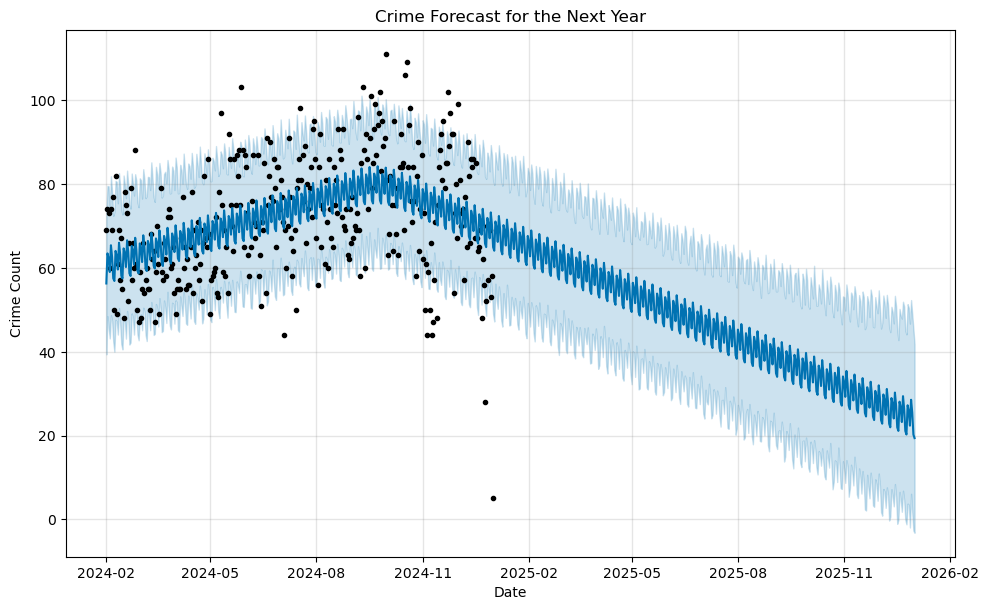

In [19]:
model = Prophet()
model.fit(filtered_data)

# Make future dataframe for prediction
future = model.make_future_dataframe(periods=365)  # Forecast for the next year
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title("Crime Forecast for the Next Year")
plt.xlabel("Date")
plt.ylabel("Crime Count")
plt.show()

# Sesonality and Trend
# fig2 = model.plot_components(forecast)
# plt.show()

#### What factors correlate most strongly with crime frequency?

In [20]:
crime_by_shift = data.groupby('shift').size().reset_index(name='crime_count') # categorical
crime_by_ward = data.groupby('ward').size().reset_index(name='crime_count') # numerical
crime_by_neighborhood = data.groupby('neighborhood_cluster').size().reset_index(name='crime_count') # categorical


In [21]:
# 1. Correlation for `ward` (numerical variable)
crime_by_ward = data.groupby('ward').size().reset_index(name='crime_count')
crime_by_ward['ward'] = pd.to_numeric(crime_by_ward['ward'], errors='coerce')
ward_correlation = crime_by_ward['ward'].corr(crime_by_ward['crime_count'])
print("Correlation between ward and crime count:", ward_correlation)


Correlation between ward and crime count: -0.2169266881464807


In [22]:

# 2. Chi-Square Test for `shift` (categorical variable)
shift_table = pd.crosstab(data['shift'], data['offense'])
chi2, p, dof, ex = chi2_contingency(shift_table)
print(f"Chi-square test for 'shift' and 'offense': chi2={chi2:.2f}, p-value={p:.2e}")


Chi-square test for 'shift' and 'offense': chi2=2048.29, p-value=0.00e+00


In [23]:
# 3. ANOVA for `neighborhood_cluster` (categorical variable)
crime_counts = data.groupby(['neighborhood_cluster', 'offense']).size().reset_index(name='crime_count')

# Pivot the data to have offenses as columns and neighborhood clusters as rows
pivot_table = crime_counts.pivot(index='neighborhood_cluster', columns='offense', values='crime_count').fillna(0)

# Prepare data for ANOVA
anova_groups = [pivot_table[col] for col in pivot_table.columns]

# Ensure there are enough groups to perform ANOVA
if len(anova_groups) > 1:
    f_stat, p_val = f_oneway(*anova_groups)
    print(f"ANOVA for neighborhood_cluster (based on offense counts): F-statistic={f_stat}, p-value={p_val}")
else:
    print("Not enough valid data for ANOVA.")


ANOVA for neighborhood_cluster (based on offense counts): F-statistic=34.379353941037195, p-value=4.172915614129191e-41


#### Geospatial analysis

In [24]:
import folium
from folium.plugins import HeatMap

# Create a base map
crime_map = folium.Map(location=[data['latitude'].mean(), data['longitude'].mean()], zoom_start=12)

# Add heatmap layer
crime_data = data[['latitude', 'longitude']].dropna()  # Ensure there are no missing values
HeatMap(data=crime_data, radius=10, blur=15).add_to(crime_map)

# Display the map
crime_map.save("crime_hotspots.html")
crime_map

In [27]:
data['offense'].value_counts()  

offense
THEFT/OTHER                   11862
THEFT F/AUTO                   6239
MOTOR VEHICLE THEFT            4606
ROBBERY                        1805
BURGLARY                        883
ASSAULT W/DANGEROUS WEAPON      812
HOMICIDE                        152
SEX ABUSE                       128
ARSON                             4
Name: count, dtype: int64

In [25]:
# Example: Analyze spatial distribution for "THEFT" crimes
theft_data = data[data['offense'] == 'THEFT/OTHER'][['latitude', 'longitude']].dropna()

# Create a theft-specific map
theft_map = folium.Map(location=[theft_data['latitude'].mean(), theft_data['longitude'].mean()], zoom_start=12)

# Add points for each theft occurrence
for _, row in theft_data.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(theft_map)

# Save and display the map
theft_map.save("theft_spatial_distribution.html")
theft_map


ValueError: Location values cannot contain NaNs.